Generating Map chart...


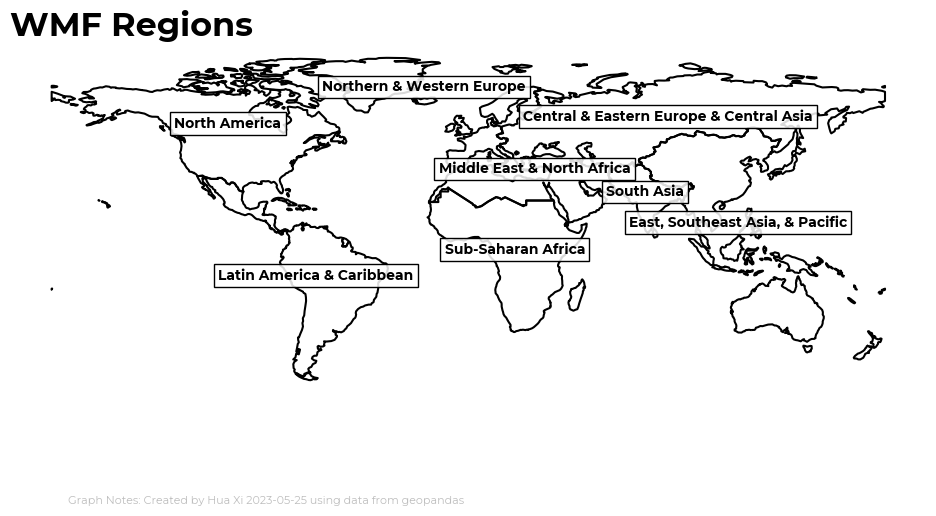

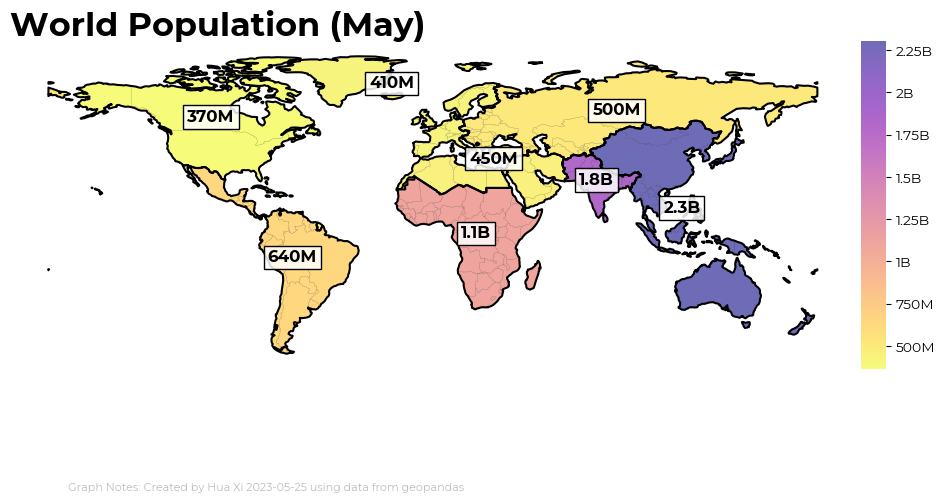

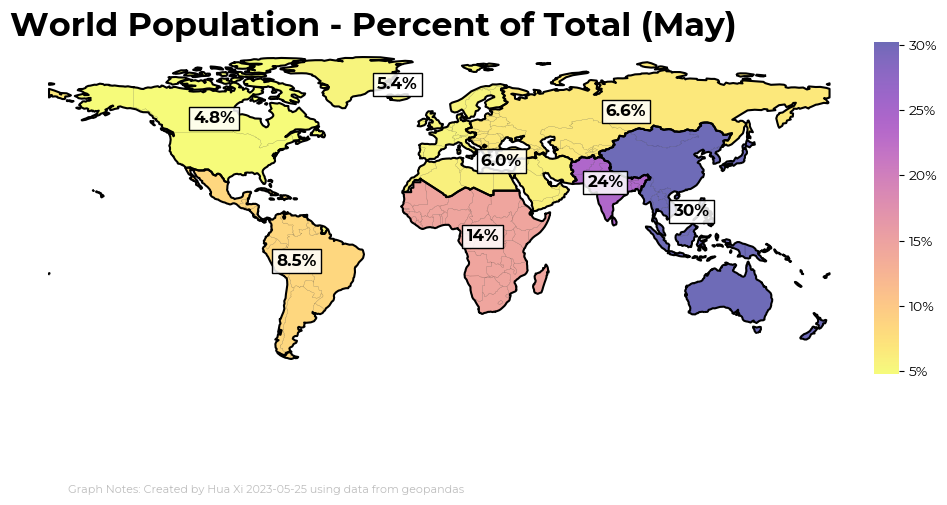

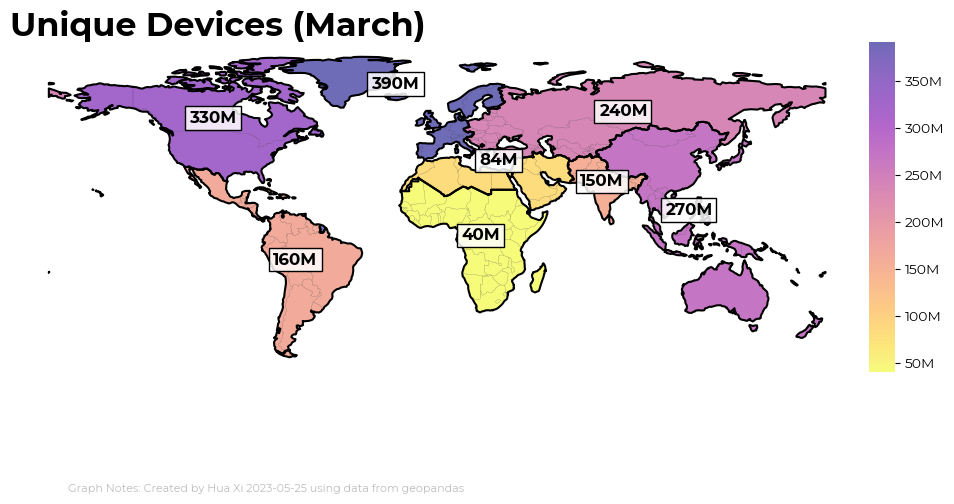

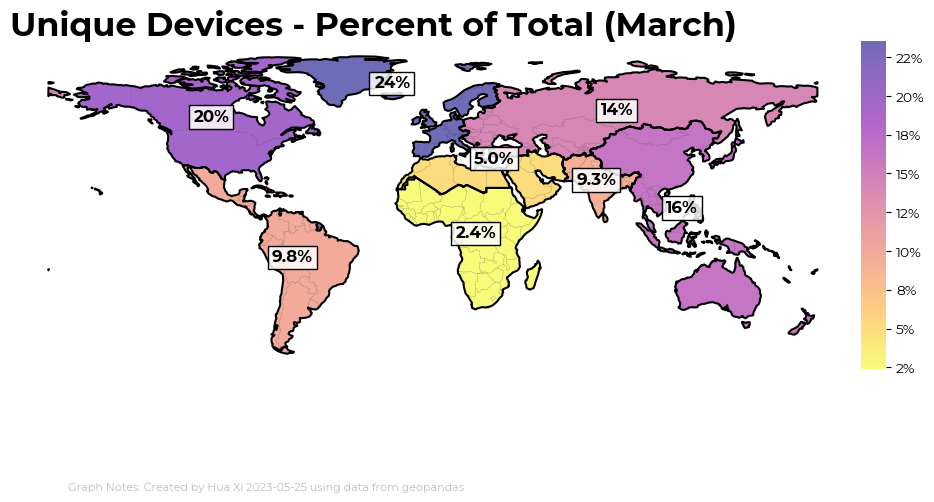

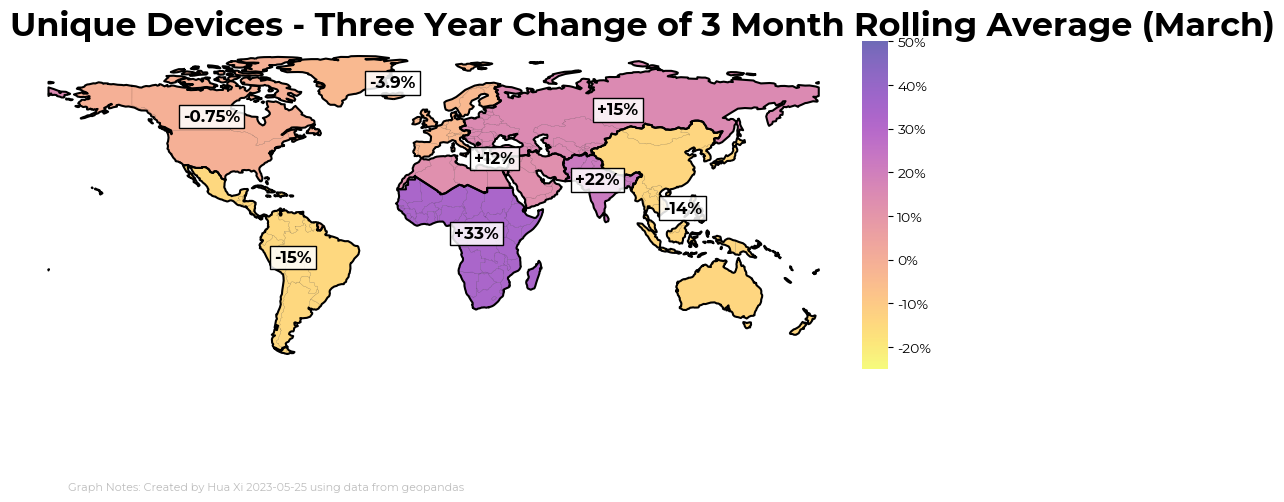

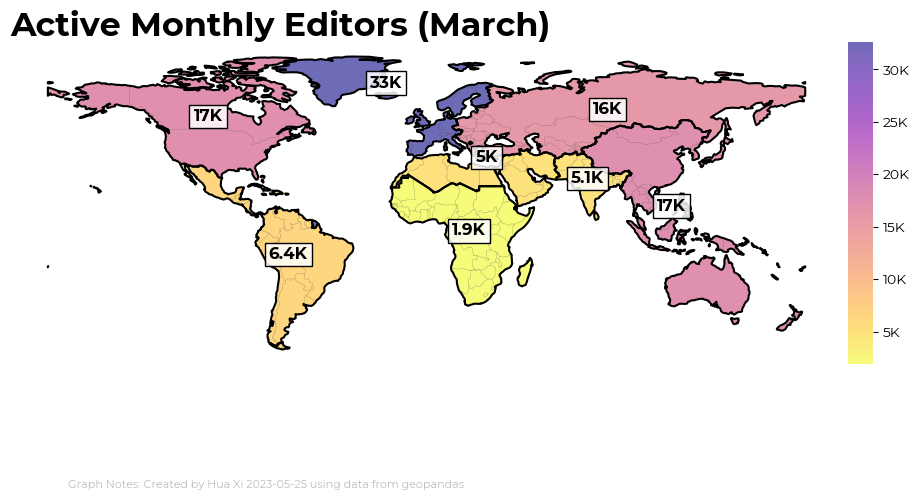

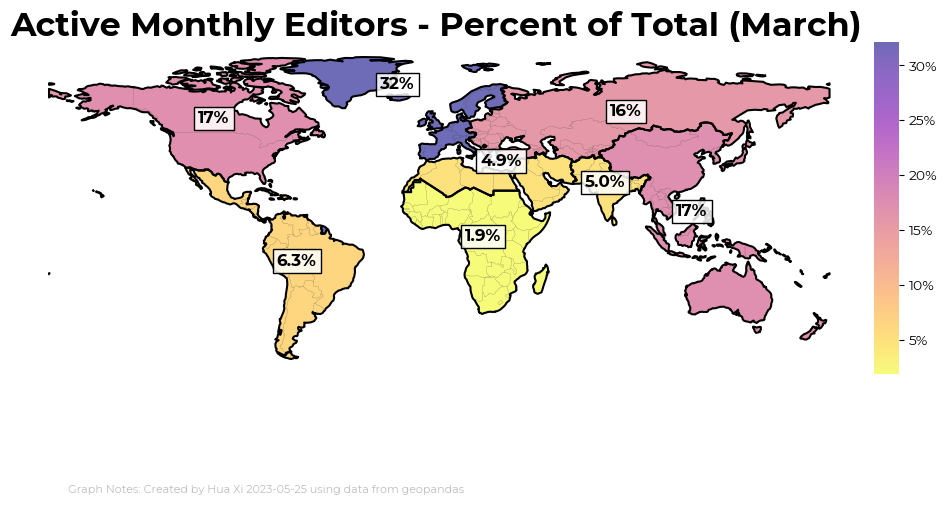

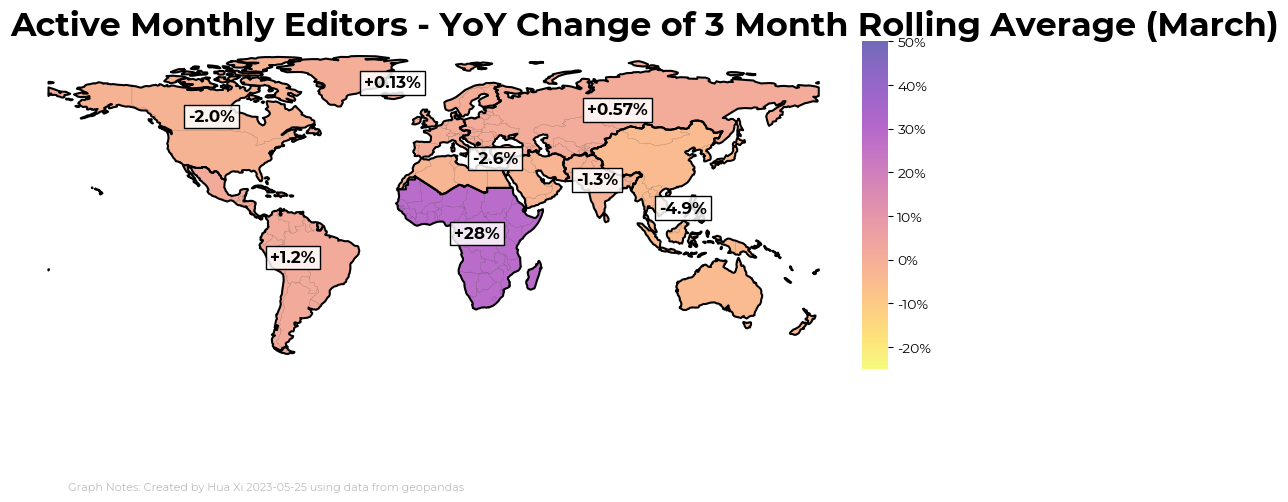

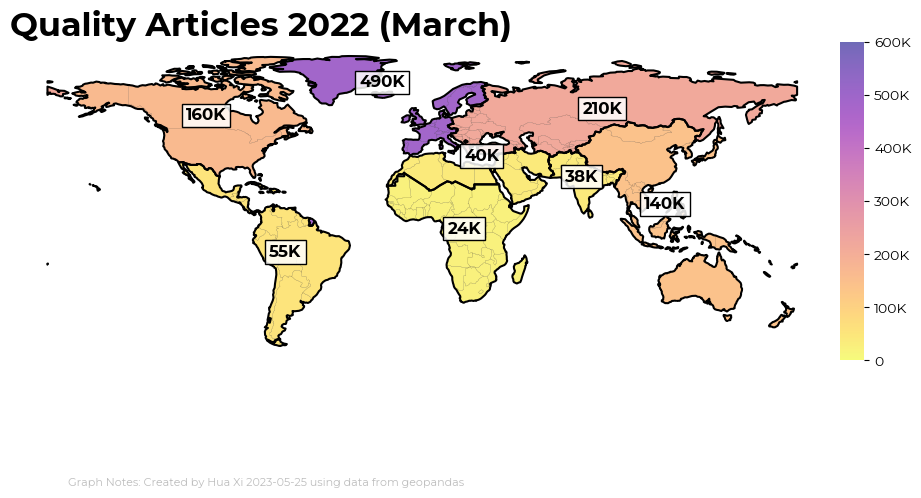

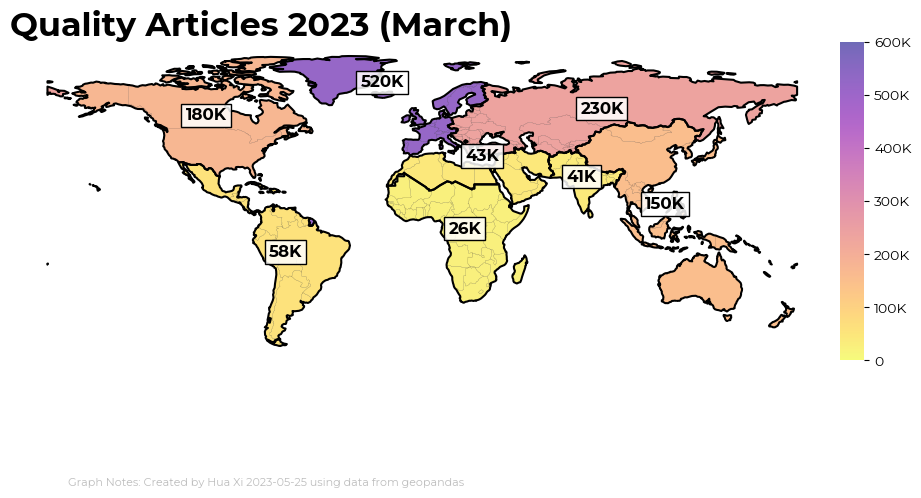

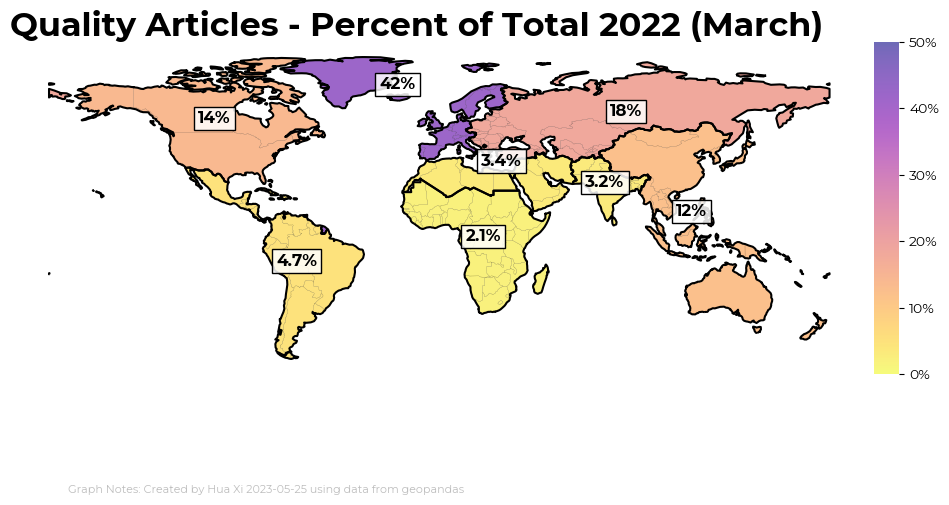

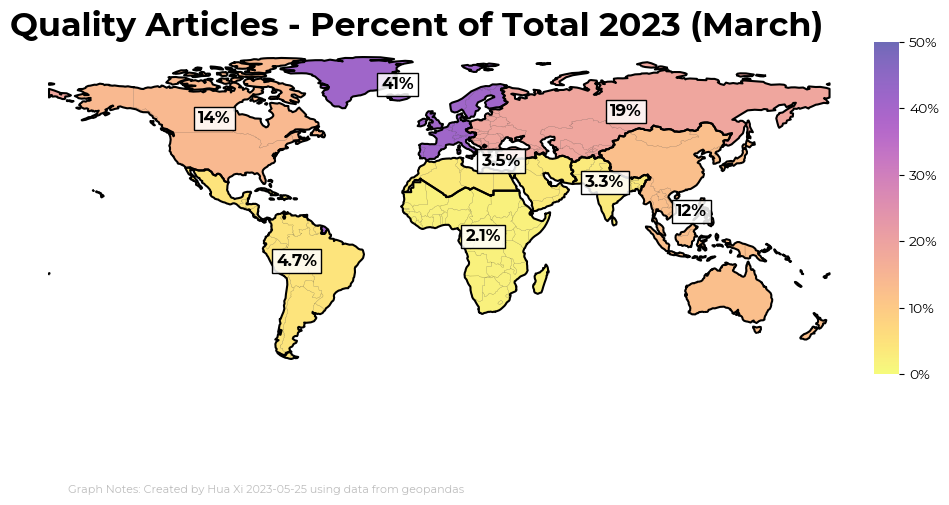

In [ ]:
import pandas as pd
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import geopandas as gpd
from math import log10, floor
import matplotlib.pyplot as plt
import numpy as np
import shapely
from shapely.ops import unary_union
import shapely.ops
import shapely.geometry
import os
from os.path import dirname
#local
#from wikicharts import Wikimap, wmf_colors, simple_num_format, wmf_regions, roll, format_perc
#jupyter notebook
%run wikicharts.ipynb

def main():
    print("Generating Map chart...")
    
    warnings.filterwarnings("ignore")

    #---PARAMETERS---
    #current path
    home_dir = os.getcwd()
    #py file only (comment out next line in jupyter notebook)
    #home_dir = dirname(home_dir)
    #display or note
    display_flag = True
    #current month for population data
    current_month = datetime.today().month

    #---WMF REGION DATA---
    #country code in iso-a3
    wmf_region_ref = pd.read_csv(home_dir + '/resources/data/wmf_region_ref.csv', sep=',')

    #---MAP (Borders) AND POPULATION DATA---
    #country code in alpha-3
    raw_map_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
    #remove antarctica
    map_df = raw_map_df[(raw_map_df.name!="Antarctica")]
    #match up wmf region data in wmf_region_ref with geographic data in map_df
    map_df = map_df.merge(wmf_region_ref, how='left', left_on="iso_a3", right_on="code")
    map_df = map_df[['name_x','iso_a3', 'pop_est', 'gdp_md_est', 'geometry', 'wmf_region']]
    map_df = map_df.rename(columns={"name_x": "name"})
    #create pivot
    region_table = pd.pivot_table(map_df, values='pop_est', index=['wmf_region'], aggfunc=np.sum)
    region_table = region_table.rename(columns={'pop_est': 'sum_pop_est'})
    #map_df = map_df.merge(region_table, how='left', left_on="wmf_region", right_on="wmf_region")
    #print(type(map_df))
    #generate regional linestrings
    region_table['geometry'] = ''
    for region in wmf_regions:
        region_df = map_df.loc[map_df['wmf_region'] == region]
        region_polys = region_df['geometry'].values.tolist()
        region_boundary = gpd.GeoSeries(unary_union(region_polys))
        region_table.at[region,'geometry'] = region_boundary
    #get representative centroid xys for each region
    region_table['centroid'] = region_table['geometry'].apply(lambda g: g.centroid)
    #region_table.to_csv("region_geometries.csv")

    #---READER DATA---
    #clean and merge reader data
    #Data Columns: "month" (in YYYY-MM format), "region", "unique_devices"
    reader_df = pd.read_csv(home_dir + '/resources/data/regional_reader_metrics.csv')
    #clean
    reader_df['month'] = pd.to_datetime(reader_df['month'])
    reader_df = reader_df.sort_values(by='month')
    reader_df = reader_df[~reader_df.region.isin(['UNCLASSED',np.nan])]
    #get the last month and get table with just last months values
    reader_lastmonth = reader_df.iloc[-1]['month'].month
    reader_df_lastmonth = reader_df.loc[reader_df['month'] == reader_df.iloc[-1]['month']]
    #merge with wmf regions table
    region_table = region_table.merge(reader_df_lastmonth, how='left', left_on="wmf_region", right_on="region").set_axis(region_table.index)
    region_table = region_table.rename(columns={"region": "region_name"})
    region_table = region_table.drop(columns=['month'])

    #---EDITOR DATA---
    #clean and merge editor data
    #Data Columns: "month" (in YYYY-MM format), "sum(editors)", "wmf_region"
    editor_df = pd.read_csv(home_dir + '/resources/data/regional_editor_metrics.csv')
    #clean
    editor_df = editor_df.rename(columns={"sum(editors)": "monthly_editors","wmf_region":"region"})
    editor_df['month'] = pd.to_datetime(editor_df['month'])
    editor_df = editor_df.sort_values(by='month')
    editor_df = editor_df[~editor_df.region.isin(['UNCLASSED',np.nan])]
    #get the last month and get table with just last months values
    editor_lastmonth = editor_df.iloc[-1]['month'].month
    editor_df_lastmonth = editor_df.loc[editor_df['month'] == editor_df.iloc[-1]['month']]
    #merge with wmf regions table
    region_table = region_table.merge(editor_df_lastmonth, how='left', left_on="wmf_region", right_on="region").set_axis(region_table.index)
    region_table = region_table.drop(columns=['month','region'])

    #---CONTENT DATA---
    #clean and merge content data
    #Data Columns: "region", "time_bucket", "standard_quality", "standard_quality_count'
    content_df = pd.read_csv(home_dir + '/resources/data/content_quality.csv')
    #clean
    content_df = content_df.rename(columns={"time_bucket":"month"})
    content_df = content_df.drop(columns=['standard_quality'])
    content_df['month'] = pd.to_datetime(content_df['month'])
    content_df = content_df.sort_values(by='month')
    content_df = content_df[~content_df.region.isin(['UNCLASSED',np.nan])]
    #get the last month and get table with just last months values
    content_lastmonth = content_df.iloc[-1]['month'].month
    content_df_lastmonth = content_df.loc[content_df['month'] == content_df.iloc[-1]['month']]
    #merge with wmf regions table
    region_table = region_table.merge(content_df_lastmonth, how='left', left_on="wmf_region", right_on="region").set_axis(region_table.index)
    region_table = region_table.drop(columns=['month','region'])

    #---VALUES---
    region_table['pop_label'] = region_table['sum_pop_est'].apply(simple_num_format, round_sigfigs=True)
    region_table['ud_label'] = region_table['unique_devices'].apply(simple_num_format, round_sigfigs=True)
    region_table['ed_label'] = region_table['monthly_editors'].apply(simple_num_format, round_sigfigs=True)
    region_table['sqc_label'] = region_table['standard_quality_count'].apply(simple_num_format, round_sigfigs=True)

    #---PERCENT OF TOTAL---
    region_table['pop_perc'] = (region_table['sum_pop_est'] / region_table['sum_pop_est'].sum()) * 100
    region_table['pop_perc_label'] = region_table["pop_perc"].apply(format_perc, sign = False)
    region_table['ud_perc'] = ((region_table['unique_devices'] / region_table['unique_devices'].sum()) * 100)
    region_table['ud_perc_label'] = region_table['ud_perc'].apply(format_perc, sign = False)
    region_table['ed_perc'] = ((region_table['monthly_editors'] / region_table['monthly_editors'].sum()) * 100)
    region_table['ed_perc_label'] = region_table['ed_perc'].apply(format_perc, sign = False)
    region_table['sqc_perc'] = ((region_table['standard_quality_count'] / region_table['standard_quality_count'].sum()) * 100)
    region_table['sqc_perc_label'] = region_table['sqc_perc'].apply(format_perc, sign = False)
    #quality articles 2022 percent of total
    prev_time = content_df.iloc[-1]['month'].replace(day=1) - relativedelta(years=1)
    content_df_22 = content_df.loc[content_df['month'] == prev_time]
    content_df_22['sqc_perc_22'] = ((content_df_22['standard_quality_count'] / content_df_22['standard_quality_count'].sum()) * 100)
    content_df_22['sqc_perc_22_label'] = content_df_22['sqc_perc_22'].apply(format_perc, sign = False)
    content_df_22 = content_df_22.rename(columns={'standard_quality_count':'standard_quality_count_22'})
    region_table = region_table.merge(content_df_22, how='left', left_on="wmf_region", right_on="region").set_axis(region_table.index)
    region_table = region_table.drop(columns=['month','region'])
    region_table['sqc_label_22'] = region_table['standard_quality_count_22'].apply(simple_num_format, round_sigfigs=True)

    #---CHANGE OVER TIME---
    def change_over_time(var, change_var_name, data_df, region_table_local, days_delta = 0, months_delta=0, years_delta = 0):
        #get data for the most recent month
        current_df = data_df.loc[data_df['month'] == data_df.iloc[-1]['month']]
        #get data for time delta
        prev_time = data_df.iloc[-1]['month'].replace(day=1) - relativedelta(years=years_delta, months=months_delta, days=days_delta)
        prev_df = data_df.loc[data_df['month'] == prev_time]
        #names and labels
        var_x = var + "_x"
        var_y = var + "_y"	
        growth_var_label = change_var_name + "_label"
        #comparison df
        growth_df = current_df.merge(prev_df, how='left',left_on="region", right_on="region")
        growth_df = growth_df.rename(columns={var_x:"current",var_y:"prev"})
        growth_df = growth_df.drop(columns=['month_x','month_y'])
        growth_df[change_var_name] = (growth_df["current"] - growth_df["prev"]) / growth_df["prev"] *  100
        growth_df[growth_var_label] = growth_df[change_var_name].map(format_perc)
        region_table_local = region_table_local.merge(growth_df.drop(columns=["current", "prev"]), how='left', left_on="wmf_region", right_on="region").set_axis(region_table.index)
        region_table_local = region_table_local.drop(columns=['region'])
        return region_table_local

    #---YOY (Simple YOY for Content Only)---
    region_table = change_over_time("standard_quality_count", "sqc_yoy", content_df, region_table, years_delta=1)
    #---YOY of ROLLING AVERAGE---
    #get rolling average charts
    reader_pivot = pd.pivot_table(reader_df, values='unique_devices', index=['month'], columns=['region'], aggfunc=np.sum)
    reader_rolling3mo = reader_pivot.apply(lambda x: x.rolling(window=3).mean()).reset_index()
    reader_rolling3mo = pd.melt(reader_rolling3mo, id_vars="month", value_vars=wmf_regions)
    editor_pivot = pd.pivot_table(editor_df, values='monthly_editors', index=['month'], columns=['region'], aggfunc=np.sum)
    editor_rolling3mo = editor_pivot.apply(lambda x: x.rolling(window=3).mean()).reset_index()
    editor_rolling3mo = pd.melt(editor_rolling3mo, id_vars="month", value_vars=wmf_regions)
    #YOY of Rolling Average, note unique devices compares 3 year difference
    region_table = change_over_time("value", "ud_3morolling_yoy", reader_rolling3mo, region_table, years_delta=3)
    region_table = change_over_time("value", "ed_3morolling_yoy", editor_rolling3mo, region_table, years_delta=1)

    #---REMERGE W MAP_DF
    #merge pivot table with map data again — for generating colorbar
    #need to drop the geometry data from region_table or you will end up with a regular dataframe instead of a geoseries dataframe
    map_df = map_df.merge(region_table.drop(columns=['geometry','centroid']), how='left', left_on="wmf_region", right_on="wmf_region")

    #---ADDITIONAL LABELS---
    #manually adjust positions (very complicated to do programmatically in matplotlib and not necessary)
    region_table["region_label_positions"] = region_table['centroid']
    mena = region_table.at['Middle East & North Africa','centroid']
    region_table.at['Middle East & North Africa','centroid'] = shapely.Point(mena.x,mena.y + 8)
    nwe = region_table.at['Northern & Western Europe','centroid']
    region_table.at['Northern & Western Europe','centroid'] = shapely.Point(nwe.x,nwe.y + 5)


    #---MAKE CHART---
    #---BLANK MAP WITH REGIONS LABELS---
    chart = Wikimap(map_df, fignum=0, title = 'WMF Regions', data_source="geopandas", month=current_month, display_month=False)
    chart.plot_regions(region_table, 'region_name', fontsize=10)
    chart.format_map(format_colobar=False)
    save_file_name = home_dir + "/charts/Map_RegionNames.png"
    chart.finalize_plot(save_file_name,display=True)

    #---WORLD POPULATION---
    chart = Wikimap(map_df, fignum=1, title = 'World Population', data_source="geopandas", month=current_month)
    chart.plot_wcolorbar(col = 'sum_pop_est')
    chart.plot_regions(region_table, 'pop_label')
    chart.format_map()
    save_file_name = home_dir + "/charts/Map_WorldPop.png"
    chart.finalize_plot(save_file_name,display=True)

    #---WORLD POPULATION - PERCENT---
    chart = Wikimap(map_df, fignum=2, title = 'World Population - Percent of Total', data_source="geopandas", month=current_month)
    chart.plot_wcolorbar(col = 'pop_perc')
    chart.plot_regions(region_table,'pop_perc_label')
    chart.format_map(cbar_perc=True)
    save_file_name = home_dir + "/charts/Map_WorldPopPerc.png"
    chart.finalize_plot(save_file_name,display=True)

    #---READER METRICS - UNIQUE DEVICES---
    chart = Wikimap(map_df, fignum=3, title = 'Unique Devices', data_source="geopandas", month=reader_lastmonth)
    chart.plot_wcolorbar(col = 'unique_devices')
    chart.plot_regions(region_table, 'ud_label')
    chart.format_map()
    save_file_name = home_dir + "/charts/Map_UniqueDevices.png"
    chart.finalize_plot(save_file_name,display=True)

    #---READER METRICS - UNIQUE DEVICES PERCENT---
    chart = Wikimap(map_df, fignum=4, title = 'Unique Devices - Percent of Total', data_source="geopandas", month=reader_lastmonth)
    chart.plot_wcolorbar(col = 'ud_perc')
    chart.plot_regions(region_table,'ud_perc_label')
    chart.format_map(cbar_perc=True)
    save_file_name = home_dir + "/charts/Map_UniqueDevicesPerc.png"
    chart.finalize_plot(save_file_name,display=True)

    #---READER METRICS - UNIQUE DEVICES YOY of 3MO ROLLING Average---
    chart = Wikimap(map_df, fignum=6, title = 'Unique Devices - Three Year Change of 3 Month Rolling Average', data_source="geopandas", month=reader_lastmonth)
    chart.plot_wcolorbar(col = 'ud_3morolling_yoy', setlimits=True)
    chart.plot_regions(region_table,'ud_3morolling_yoy_label')
    chart.format_map(cbar_perc=True)
    save_file_name = home_dir + "/charts/Map_UniqueDevices3moRollingYoy.png"
    chart.finalize_plot(save_file_name,display=True)

    #---EDITOR METRICS - ACTIVE MONTHLY EDITORS---
    chart = Wikimap(map_df, fignum=7, title = 'Active Monthly Editors', data_source="geopandas", month=editor_lastmonth)
    chart.plot_wcolorbar(col = 'monthly_editors')
    chart.plot_regions(region_table, 'ed_label')
    chart.format_map()
    save_file_name = home_dir + "/charts/Map_Editors.png"
    chart.finalize_plot(save_file_name,display=True)

    #---EDITOR METRICS - ACTIVE MONTHLY EDITORS PERC---
    chart = Wikimap(map_df, fignum=8, title = 'Active Monthly Editors - Percent of Total', data_source="geopandas", month=editor_lastmonth)
    chart.plot_wcolorbar(col = 'ed_perc')
    chart.plot_regions(region_table, 'ed_perc_label')
    chart.format_map(cbar_perc=True)
    save_file_name = home_dir + "/charts/Map_EditorsPerc.png"
    chart.finalize_plot(save_file_name,display=True)

    #---EDITOR METRICS - EDITORS YOY of 3MO ROLLING Average---
    chart = Wikimap(map_df, fignum=6, title = 'Active Monthly Editors - YoY Change of 3 Month Rolling Average', data_source="geopandas", month=editor_lastmonth)
    chart.plot_wcolorbar(col = 'ed_3morolling_yoy', setlimits=True)
    chart.plot_regions(region_table,'ed_3morolling_yoy_label')
    chart.format_map(cbar_perc=True)
    save_file_name = home_dir + "/charts/Map_Editors3moRollingYoy.png"
    chart.finalize_plot(save_file_name,display=True)

    #---CONTENT METRICS - COUNT---
    chart = Wikimap(map_df, fignum=10, title = 'Quality Articles 2022', data_source="geopandas", month=content_lastmonth)
    chart.plot_wcolorbar(col = 'standard_quality_count_22', setlimits=True, custom_vmin=0, custom_vmax=600000)
    chart.plot_regions(region_table,'sqc_label_22')
    chart.format_map()
    save_file_name = home_dir + "/charts/Map_Content22.png"
    chart.finalize_plot(save_file_name,display=True)

    #---CONTENT METRICS - COUNT---
    chart = Wikimap(map_df, fignum=10, title = 'Quality Articles 2023', data_source="geopandas", month=content_lastmonth)
    chart.plot_wcolorbar(col = 'standard_quality_count', setlimits=True, custom_vmin=0, custom_vmax=600000)
    chart.plot_regions(region_table,'sqc_label')
    chart.format_map()
    save_file_name = home_dir + "/charts/Map_Content23.png"
    chart.finalize_plot(save_file_name,display=True)

    #---CONTENT METRICS - PERCENT TOTAL 2022---
    chart = Wikimap(map_df, fignum=11, title = 'Quality Articles - Percent of Total 2022', data_source="geopandas", month=content_lastmonth)
    chart.plot_wcolorbar(col = 'sqc_perc_22', setlimits=True, custom_vmin=0, custom_vmax=50)
    chart.plot_regions(region_table,'sqc_perc_22_label')
    chart.format_map(cbar_perc=True)
    save_file_name = home_dir + "/charts/Map_ContentPerc22.png"
    chart.finalize_plot(save_file_name,display=True)

    #---CONTENT METRICS - PERCENT TOTAL 2023---
    chart = Wikimap(map_df, fignum=12, title = 'Quality Articles - Percent of Total 2023', data_source="geopandas", month=content_lastmonth)
    chart.plot_wcolorbar(col = 'sqc_perc', setlimits=True, custom_vmin=0, custom_vmax=50)
    chart.plot_regions(region_table,'sqc_perc_label')
    chart.format_map(cbar_perc=True)
    save_file_name = home_dir + "/charts/Map_ContentPerc23.png"
    chart.finalize_plot(save_file_name,display=True)


    #---CONTENT METRICS - YOY of 3MO ROLLING Average---
    chart = Wikimap(map_df, fignum=13, title = 'Quality Articles - YoY', data_source="geopandas", month=content_lastmonth)
    chart.plot_wcolorbar(col = 'sqc_yoy', setlimits=True)
    chart.plot_regions(region_table, 'sqc_yoy_label')
    chart.format_map(cbar_perc=True)
    save_file_name = home_dir + "/charts/Map_ContentYoY.png"
    chart.finalize_plot(save_file_name,display=True)

if __name__ == "__main__":
    main()
